In [565]:

import os, cv2, random
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score, roc_curve, auc

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from matplotlib import style
style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


### Look on images description

In results.csv is image description file, Where for each image we can see it gender 0 or 1. 

0 - male

1 - female

In [566]:
# Load All file
imgFilesDir = "./final/"
data = pd.read_csv('results.csv')
data.head()

,Filename,Gender,Age
0,Raw_0001_001_20050913115022_Portrait.png,1,1
1,Raw_0002_002_20050913094354_Portrait.png,1,1
2,Raw_0003_003_20050913094955_Portrait.png,0,0
3,Raw_0005_004_20050913101316_Portrait.png,1,1
4,Raw_0007_005_20050913093707_Portrait.png,0,1


In [567]:
# loading labels for each image from csv
data = pd.read_csv('results.csv')
labels = data.iloc[:,0:2]

### Male images

In [568]:

# Separating male labels
male_data = labels[labels['Gender'] == 0]
male_data.head()

,Filename,Gender
2,Raw_0003_003_20050913094955_Portrait.png,0
4,Raw_0007_005_20050913093707_Portrait.png,0
5,Raw_0009_006_20050913122608_Portrait.png,0
6,Raw_0010_007_20050913094809_Portrait.png,0
7,Raw_0011_008_20050913123954_Portrait.png,0


### Female images

In [569]:
# Separating female labels
female_data = labels[labels['Gender'] == 1]
female_data.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
3,Raw_0005_004_20050913101316_Portrait.png,1
9,Raw_0014_010_20050913093018_Portrait.png,1
22,Raw_0039_023_20050913110844_Portrait.png,1


In [570]:
print("Female dataset shape: " + str(female_data.shape))
print("Male dataset shape: " + str(male_data.shape))

Female dataset shape: (32, 2)
Male dataset shape: (84, 2)


In [571]:
### Select number of images to test datat set for botj male and femele sets.
nToTest = 5

In [572]:

# Splitting male data into train and test
test_female_data = female_data.iloc[-nToTest:,:]
train_female_data = female_data.iloc[:-nToTest,:]

### Let`s look on some images from amle and female datatset

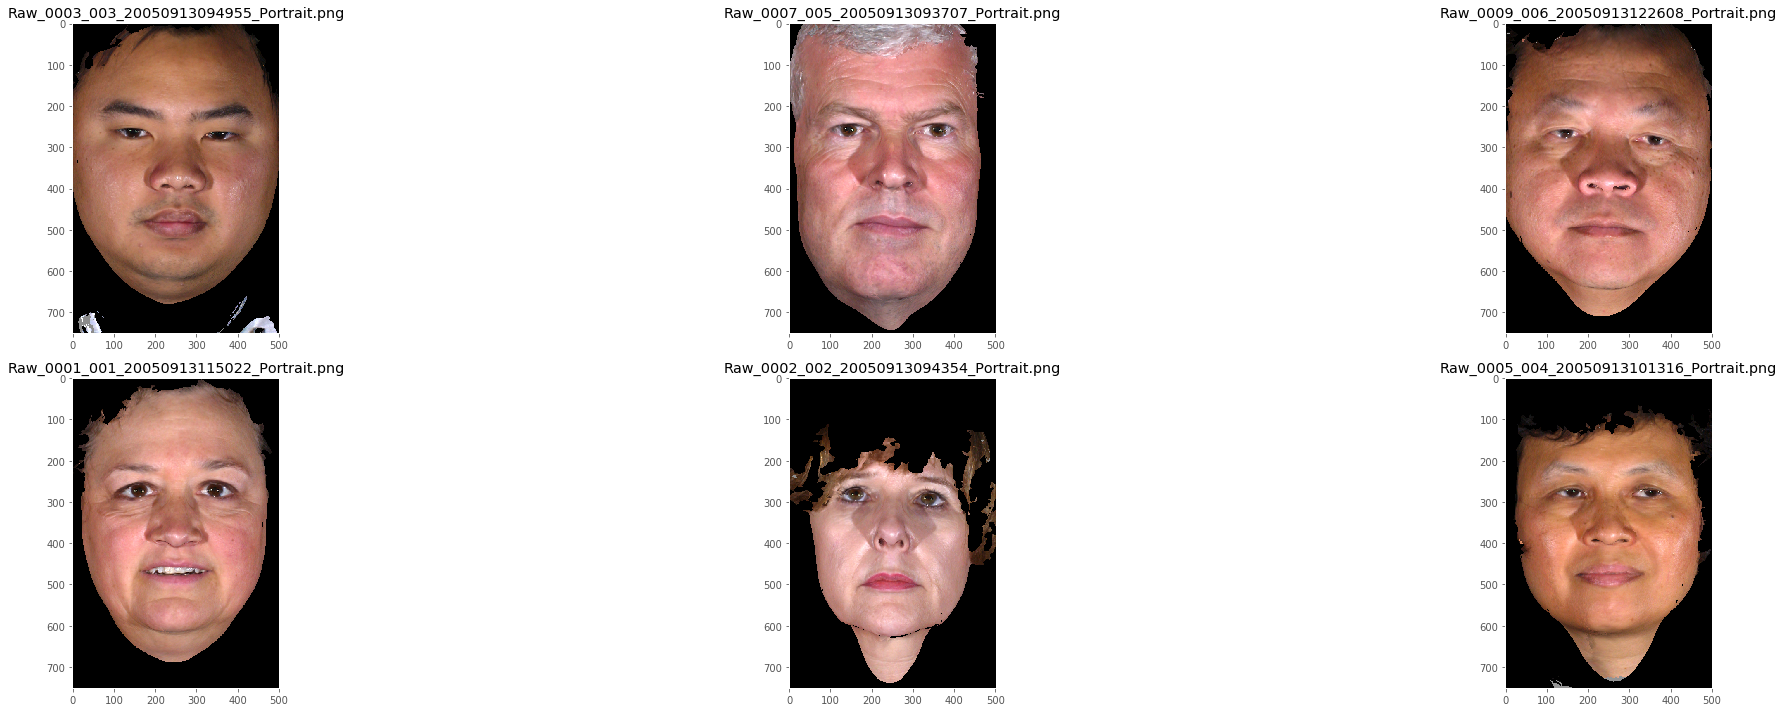

In [573]:
num_rows = 2
num_cols = 3
num_images = num_rows*num_cols
imagesToPlot = male_data.Filename.iloc[:3].tolist() +  female_data.Filename.iloc[:3].tolist()
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i,img in enumerate(imagesToPlot):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    imag=mpimg.imread(imgFilesDir + img)
    plt.imshow(imag)
    plt.title(img)
    plt.grid(False)
plt.tight_layout()
plt.show()

### Combinae test data set

In [574]:
# total test data
test_indices = test_female_data.index.tolist() + test_male_data.index.tolist()
test_data = labels.iloc[test_indices,:]
test_data.head()

,Filename,Gender
97,Raw_0356_098_20050913172749_Portrait.png,1
99,Raw_0385_100_20050912175151_Portrait.png,1
100,Raw_0471_101_20050912225308_Portrait.png,1
108,Raw_0853_111_20050913155042_Portrait.png,1
111,Raw_0939_114_20050912231742_Portrait.png,1


### Combine train datat set

In [575]:

# total train data
train_data = pd.concat([labels, test_data, test_data]).drop_duplicates(keep=False)
train_data.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
2,Raw_0003_003_20050913094955_Portrait.png,0
3,Raw_0005_004_20050913101316_Portrait.png,1
4,Raw_0007_005_20050913093707_Portrait.png,0


### Let`s look on 'Gender' distribution in whole data set

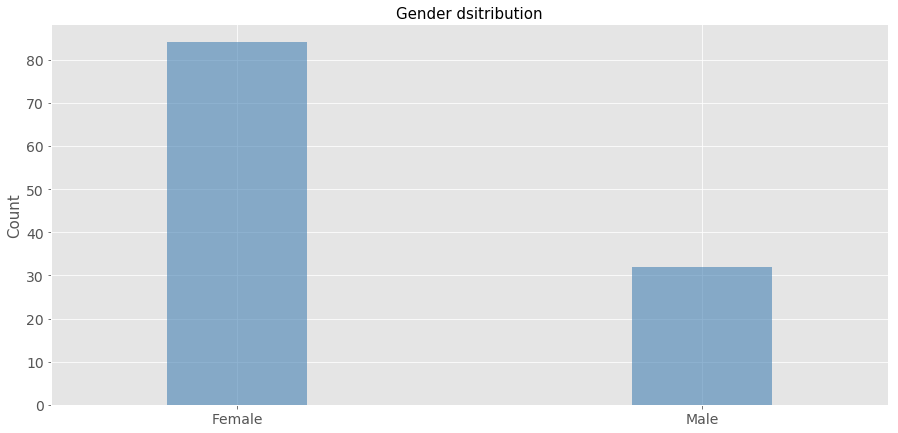

In [576]:
dd = data.copy()
dd["Gender2"] = np.where(data.Gender==1, "Female", "Male")
f = plt.figure(figsize=(15, 7))
ax = f.add_subplot(111)
dd.Gender2.value_counts().plot(kind='bar', color="steelblue", alpha=0.6, width=0.3, fontsize=13)
ax.set_xticklabels(dd.Gender2.unique(),rotation=0, fontsize=11)
ax.set_title("Gender dsitribution", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

In [577]:

# train and test with image name along with paths
path = './final/' # path of your image folder
train_image_name = [path+each for each in train_data['Filename'].values.tolist()]
test_image_name = [path+each for each in test_data['Filename'].values.tolist()]


# lets take first image and check it shape
imag = mpimg.imread(imgFilesDir + imagesToPlot[0])
print("Image shape: " + str(imag.shape))

Image shape: (751, 501, 3)


### Reshape image size to 64x64

**Reshape to (I, C, H, W)**
*    I: Images count
*    C: Color channels: 1-GtayScale, 3-RGB
*    H: Height of image in pixels
*    W: Width Image in pixels


In [578]:

# preparing data by processing images using opencv

ROWS = 64
COLS = 64
CHANNELS = 3

# We scale these values to a range of 0 to 1 before feeding them to the neural network. To do this, we will divide the values by 255. It is important that the training set and the test set are pre-processed equally

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    img = img / 255.0
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float32)
    #data = np.ndarray((count, COLS,  ROWS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        #if i%5 == 0: 
        #    print('Processed {} of {}'.format(i, count))
    
    return data

trainData = prep_data(train_image_name)
testData = prep_data(test_image_name)

#trainData /= 255
#testData /= 255

In [579]:
trainLabs = train_data.iloc[:,1].values.tolist()
testLabs = test_data.iloc[:,1].values.tolist()

print("Train shape: " + str(trainData.shape))
print("Test shape: " + str(testData.shape))

Train shape: (108, 3, 64, 64)
Test shape: (8, 3, 64, 64)


### Plotting female and male side by side

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


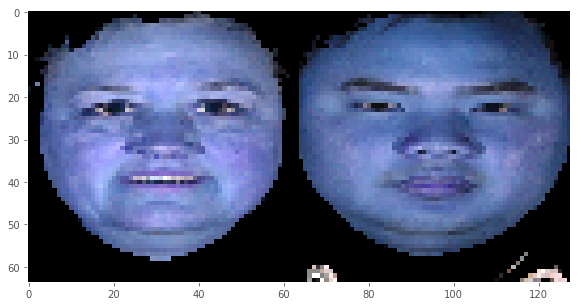

In [580]:

# plotting female and male side by side
def show_male_and_female():
    female = read_image(train_image_name[0])
    male = read_image(train_image_name[2])
    pair = np.concatenate((female, male), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.grid(False)
    plt.show()
    
show_male_and_female()

In [581]:
# splitting path of all images into male and female
train_male_image = []
train_female_image = []
for each in train_image_name:
    if each.split('/')[-1] in train_male_data['Filename'].values:
        train_male_image.append(each)
    else:
        train_female_image.append(each)

<hr>

### Let`s build NN with convolution, maxPoll and droput layers
* Set Early stop
* Set directory for best model to auto save
* loss = binary_crossentropy
* min_delta=0.0001
* Convolution kernel_size = 3x3
* MaxPolling pool_size = 2x2
* Dropout = 0.25

In [582]:

batch_size = 5
patience = 10
epochs = 30
min_delta = 0.0001
dropout = 0.25

model_name = 'keras_gender_conv.h5'
save_dir = "./models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(dropout))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(dropout))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(dropout))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))


# compiling the sequential model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model and saving metrics in history
history = model.fit(trainData, trainLabs,
          batch_size=batch_size, epochs=epochs,
          verbose=2,
          validation_data=(testData, testLabs),
          callbacks=[
            ModelCheckpoint(model_path, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=patience, min_delta=min_delta, verbose=2)
          ])

Train on 108 samples, validate on 8 samples
Epoch 1/30
 - 2s - loss: 0.8061 - accuracy: 0.5926 - val_loss: 0.6447 - val_accuracy: 0.6250
Epoch 2/30
 - 1s - loss: 0.5376 - accuracy: 0.7500 - val_loss: 0.6807 - val_accuracy: 0.7500
Epoch 3/30
 - 1s - loss: 0.5028 - accuracy: 0.7685 - val_loss: 0.4057 - val_accuracy: 0.8750
Epoch 4/30
 - 1s - loss: 0.4881 - accuracy: 0.7870 - val_loss: 0.3960 - val_accuracy: 0.7500
Epoch 5/30
 - 1s - loss: 0.4633 - accuracy: 0.8056 - val_loss: 0.4902 - val_accuracy: 0.7500
Epoch 6/30
 - 1s - loss: 0.4196 - accuracy: 0.8056 - val_loss: 1.0893 - val_accuracy: 0.3750
Epoch 7/30
 - 1s - loss: 0.4842 - accuracy: 0.7778 - val_loss: 1.3894 - val_accuracy: 0.3750
Epoch 8/30
 - 1s - loss: 0.3889 - accuracy: 0.8148 - val_loss: 1.4584 - val_accuracy: 0.3750
Epoch 9/30
 - 1s - loss: 0.2907 - accuracy: 0.8704 - val_loss: 0.3942 - val_accuracy: 0.6250
Epoch 10/30
 - 1s - loss: 0.3957 - accuracy: 0.8241 - val_loss: 0.5033 - val_accuracy: 0.7500
Epoch 11/30
 - 1s - loss:

### Convolution Nn results

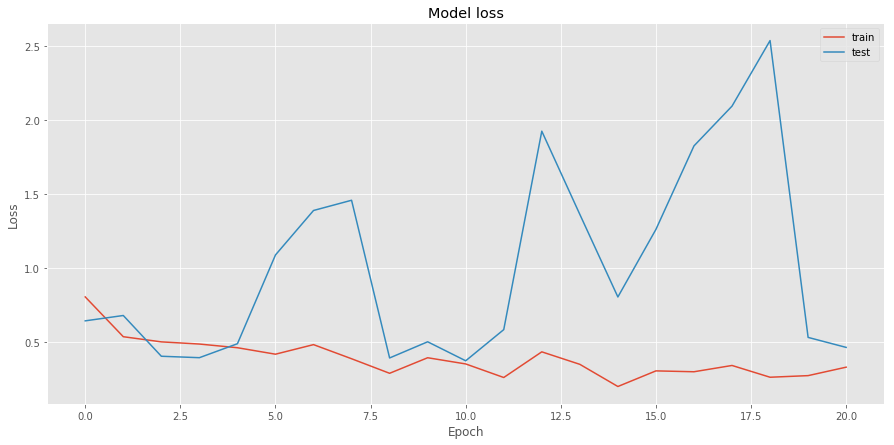

In [583]:
# plotting the metrics
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)

plt.show()

In [584]:
predictions = model.predict(testData, verbose=0)

In [585]:
roc_auc = roc_auc_score(testLabs, predictions)
print("ROC AUC: " +  str(roc_auc))

ROC AUC: 0.8666666666666667


In [586]:
acc_thresh = 0.6
print("Accuracy treshold = " + str(acc_thresh))
actual = testLabs
predicted = [0 if x<acc_thresh else 1 for x in  predictions]

results = confusion_matrix(actual, predicted) 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(actual, predicted) )
print ('Report : ')
print (classification_report(actual, predicted))


Accuracy treshold = 0.6
Confusion Matrix :
[[3 0]
 [2 3]]
Accuracy Score : 0.75
Report : 
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.60      0.75         5

    accuracy                           0.75         8
   macro avg       0.80      0.80      0.75         8
weighted avg       0.85      0.75      0.75         8



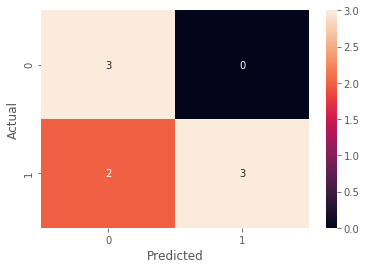

In [587]:
confusionМx = pd.crosstab(np.array(testLabs), np.array(predicted), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusionМx, annot=True)

I am 69.68% sure this is a Male


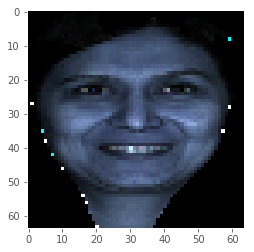

I am 99.51% sure this is a Female


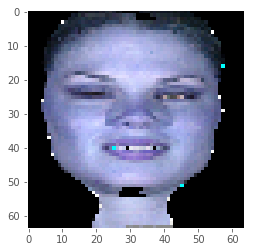

I am 97.98% sure this is a Female


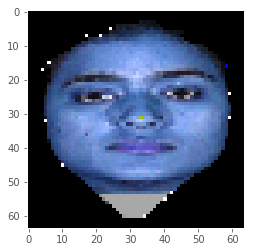

I am 85.09% sure this is a Male


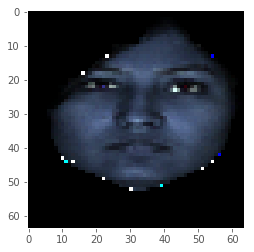

I am 87.82% sure this is a Female


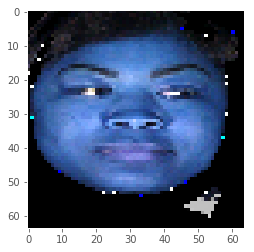

I am 77.31% sure this is a Male


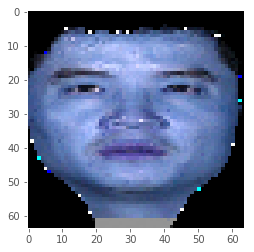

I am 99.13% sure this is a Male


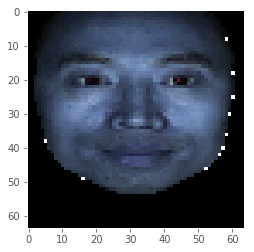

I am 81.35% sure this is a Male


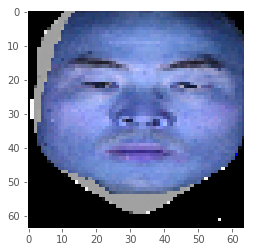

In [588]:

for i in range(0,min(20, len(predictions))):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predictions[i][0]))
        
    plt.imshow((testData[i].T * 255).astype(np.uint8))
    plt.grid(False)
    plt.show()

<hr>

### Let`s build DNN
* Set Early stop
* Set directory for best model to auto save
* loss = binary_crossentropy
* min_delta=0.0001
* Dropout = 0.25

In [589]:
batch_size = 5
patience = 10
epochs = 30
min_delta = 0.0001
dropout = 0.25

input_shape_dnn = ROWS * COLS *CHANNELS
trainDataDnn = trainData.reshape(trainData.shape[0], input_shape_dnn)
testDataDnn = testData.reshape(testData.shape[0], input_shape_dnn)

model_nameDnn = 'keras_gender_dnn.h5'
save_dir = "./models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_pathDnn = os.path.join(save_dir, model_nameDnn)


modelDnn = Sequential()

modelDnn.add(Dense(256, input_shape=(input_shape_dnn,), activation='relu'))
model.add(Dropout(dropout))

modelDnn.add(Dense(256, activation='relu'))
modelDnn.add(Dropout(dropout))

modelDnn.add(Dense(1, activation='sigmoid'))


# compiling the sequential model
modelDnn.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model and saving metrics in history
historyDnn = modelDnn.fit(trainDataDnn, trainLabs,
          batch_size=batch_size, epochs=epochs,
          verbose=2,
          validation_data=(testDataDnn, testLabs),
          callbacks=[
            ModelCheckpoint(model_pathDnn, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=patience, min_delta=min_delta, verbose=2)
          ])

Train on 108 samples, validate on 8 samples
Epoch 1/30
 - 2s - loss: 1.4067 - accuracy: 0.6759 - val_loss: 1.4465 - val_accuracy: 0.3750
Epoch 2/30
 - 1s - loss: 0.8716 - accuracy: 0.7407 - val_loss: 1.5028 - val_accuracy: 0.3750
Epoch 3/30
 - 1s - loss: 0.4896 - accuracy: 0.8056 - val_loss: 0.3295 - val_accuracy: 0.8750
Epoch 4/30
 - 1s - loss: 0.3282 - accuracy: 0.8796 - val_loss: 1.8396 - val_accuracy: 0.5000
Epoch 5/30
 - 1s - loss: 0.3300 - accuracy: 0.8333 - val_loss: 0.2090 - val_accuracy: 1.0000
Epoch 6/30
 - 1s - loss: 0.2252 - accuracy: 0.8796 - val_loss: 0.1678 - val_accuracy: 1.0000
Epoch 7/30
 - 1s - loss: 0.1727 - accuracy: 0.9352 - val_loss: 0.3400 - val_accuracy: 0.7500
Epoch 8/30
 - 1s - loss: 0.1778 - accuracy: 0.8889 - val_loss: 1.0466 - val_accuracy: 0.6250
Epoch 9/30
 - 1s - loss: 0.1689 - accuracy: 0.9537 - val_loss: 0.5601 - val_accuracy: 0.7500
Epoch 10/30
 - 1s - loss: 0.4347 - accuracy: 0.8519 - val_loss: 0.2954 - val_accuracy: 1.0000
Epoch 11/30
 - 1s - loss:

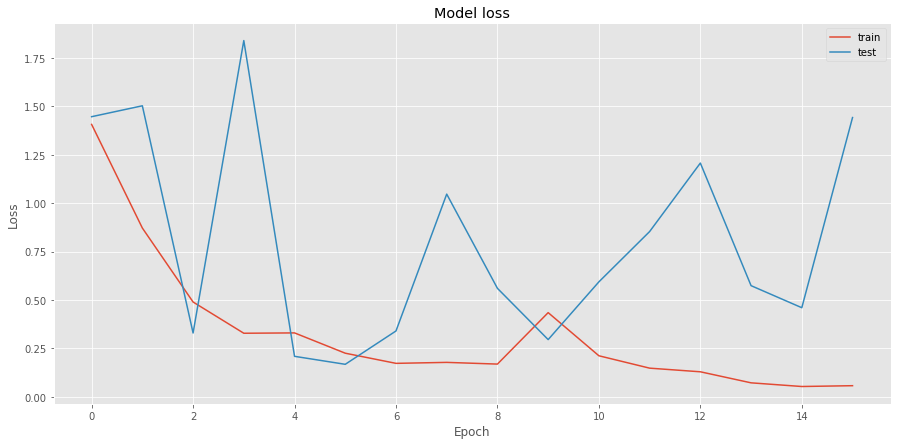

In [590]:
# plotting the metrics
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)
ax.plot(historyDnn.history['loss'])
ax.plot(historyDnn.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)

plt.show()

In [591]:
predictionsDnn = modelDnn.predict(testDataDnn, verbose=0)

In [592]:
roc_auc_dnn = roc_auc_score(testLabs, predictionsDnn.ravel())
print("ROC AUC: " +  str(roc_auc))

ROC AUC: 0.8666666666666667


In [593]:
acc_thresh = 0.6
print("Accuracy treshold = " + str(acc_thresh))
actual = testLabs
predictedDnn = [0 if x<acc_thresh else 1 for x in  predictionsDnn]

resultsDnn = confusion_matrix(actual, predictedDnn) 
print ('Confusion Matrix :')
print(resultsDnn) 
print ('Accuracy Score :',accuracy_score(actual, predictedDnn) )
print ('Report : ')
print (classification_report(actual, predictedDnn))


Accuracy treshold = 0.6
Confusion Matrix :
[[3 0]
 [3 2]]
Accuracy Score : 0.625
Report : 
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       1.00      0.40      0.57         5

    accuracy                           0.62         8
   macro avg       0.75      0.70      0.62         8
weighted avg       0.81      0.62      0.61         8



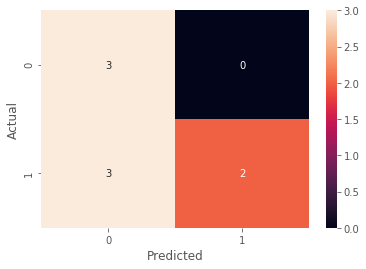

In [594]:
confusionМx = pd.crosstab(np.array(testLabs), np.array(predictedDnn), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusionМx, annot=True)

I am 82.63% sure this is a Male


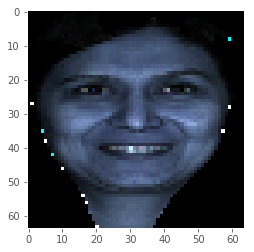

I am 3.44% sure this is a Female


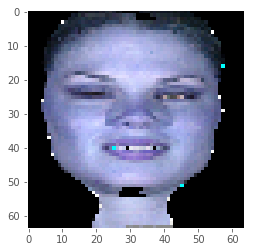

I am 85.99% sure this is a Female


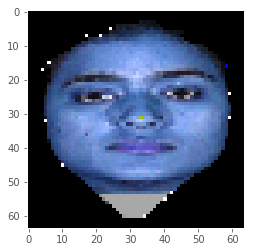

I am 24.88% sure this is a Male


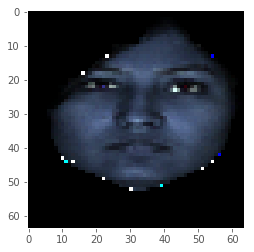

I am 0.25% sure this is a Female


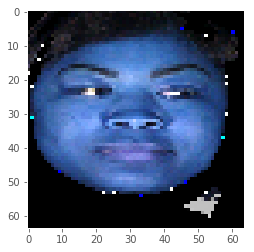

I am 100.00% sure this is a Male


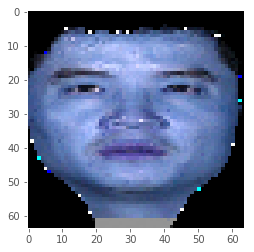

I am 99.48% sure this is a Male


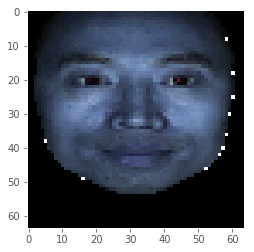

I am 99.98% sure this is a Male


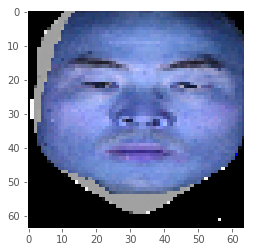

In [595]:

for i in range(0,min(20, len(predictionsDnn))):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predictionsDnn[i][0]))
    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predictionsDnn[i][0]))
        
    plt.imshow((testData[i].T * 255).astype(np.uint8))
    plt.grid(False)
    plt.show()